In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import functional as VF
from torchmetrics.classification import BinaryJaccardIndex
from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2
import pandas as pd
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import random
import json

# Preparing the data - Fill NA values

In [2]:
data_dir = './train/images/'
data_dict = []
pattern = r'well_(\d+)_patch_(\d+)\.npy'
for i, filename in enumerate(os.listdir(data_dir)):
  example = np.load(data_dir + filename)
  match = re.match(pattern, filename)
  if match:
    well_number = int(match.group(1))  # Extract well number
    patch_number = int(match.group(2)) # Extract patch number
  else:
    print("Filename format does not match the expected pattern.")  
  
  data_dict.append((filename, well_number, patch_number, example.flatten()))

df = pd.DataFrame(data=data_dict, columns=['filename', 'well_number', 'patch_number', 'data'])

In [3]:
df_y = pd.read_csv('train/y_train.csv')
df_y['Unnamed: 0'] = df_y['Unnamed: 0'] + '.npy'

In [4]:
merged = pd.merge(df, df_y, how='left', left_on='filename', right_on='Unnamed: 0')
data_columns = [str(i) for i in range(1296)]
labeled_data = merged[data_columns].to_numpy()
merged['labels'] = labeled_data.tolist()
merged = merged.rename(columns={'Unnamed: 0':'label_name'})

In [5]:
matched_wells = merged[merged['label_name'].notna()]

In [6]:
# This confirms that all values for which we have a label have at least one value above 0.0
# So we can fill missing values with 0.0

non_zero_columns = (matched_wells[data_columns] != 0.0).any()
non_zero_columns = non_zero_columns[non_zero_columns == True]
matched_wells[non_zero_columns.index]

,3,4,5,6,7,8,9,10,11,16,...,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [7]:
merged = pd.merge(df, df_y, how='left', left_on='filename', right_on='Unnamed: 0')
data_columns = [str(i) for i in range(1296)]
labeled_data = merged[data_columns].to_numpy()
labeled_data = np.nan_to_num(labeled_data)
merged['labels'] = labeled_data.tolist()
merged = merged.rename(columns={'Unnamed: 0':'label_name'})
merged = merged.fillna(0.0)

# Look for outlier values

In [8]:
data = torch.from_numpy(np.vstack(merged['data'].to_numpy(dtype=np.ndarray)))
data.shape

torch.Size([2538, 1296])

(array([ 175.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2363.]),
 array([-9.99250000e+02, -8.99326050e+02, -7.99402039e+02, -6.99478088e+02,
        -5.99554077e+02, -4.99630096e+02, -3.99706116e+02, -2.99782166e+02,
        -1.99858170e+02, -9.99341965e+01, -1.02152824e-02]),
 <BarContainer object of 10 artists>)

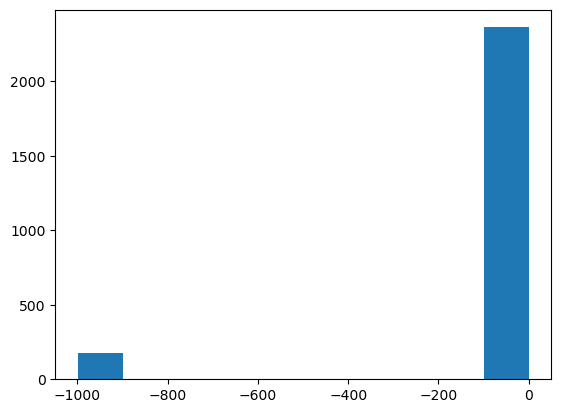

In [9]:
plt.hist(data.min(dim=1, keepdim=True).values.flatten())

In [10]:
outliers = ((data.min(dim=1, keepdim=True).values == -999.2500) == True).flatten()
outliers.shape

torch.Size([2538])

In [11]:
merged = merged.drop(merged.loc[outliers.tolist()].index)

# Set up DataLoader

In [3]:
class WellsDataset(Dataset):
    def __init__(self, data, labels, transform):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = False
        self.scaler = RobustScaler()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
def build_dataframe():
    data_dir = './train/images/'
    data_dict = []
    pattern = r'well_(\d+)_patch_(\d+)\.npy'
    for i, filename in enumerate(os.listdir(data_dir)):
        example = np.load(data_dir + filename)
        match = re.match(pattern, filename)
        if match:
            well_number = int(match.group(1))  # Extract well number
            patch_number = int(match.group(2)) # Extract patch number
        else:
            print("Filename format does not match the expected pattern.")  

        data_dict.append((filename, well_number, patch_number, example.flatten()))

    df = pd.DataFrame(data=data_dict, columns=['filename', 'well_number', 'patch_number', 'data'])

    df_y = pd.read_csv('train/y_train.csv')
    df_y['Unnamed: 0'] = df_y['Unnamed: 0'] + '.npy'

    # Create single dataframe with data and labels as lists
    merged = pd.merge(df, df_y, how='left', left_on='filename', right_on='Unnamed: 0')
    data_columns = [str(i) for i in range(1296)]
    labeled_data = merged[data_columns].to_numpy()
    # Convert missing labels to all zeros
    labeled_data = np.nan_to_num(labeled_data)
    merged['labels'] = labeled_data.tolist()
    merged = merged.rename(columns={'Unnamed: 0':'label_name'})
    merged = merged.fillna(0.0)

    data = torch.from_numpy(np.vstack(merged['data'].to_numpy(dtype=np.ndarray)))
    # Remove corruputed samples
    outliers = ((data.min(dim=1, keepdim=True).values == -999.2500) == True).flatten()

    merged = merged.drop(merged.loc[outliers.tolist()].index)
    return merged

def build_dataloaders(dataframe):
    data = torch.from_numpy(np.vstack(dataframe['data'].to_numpy()))
    data = torch.nan_to_num(data)
    labels = torch.from_numpy(np.vstack(dataframe['labels'].to_numpy()))

    p = np.random.permutation(len(data))
    with open('train_set_permutation.json', 'w') as f:
        # Write permutation to file so that we can re-apply the same transform later
        json.dump(p.tolist(), f)

    data, labels = data[p], labels[p]

    offset = int(len(data) * .8)
    X_train, X_valid = data[:offset], data[offset:]
    Y_train, Y_valid = labels[:offset].float().reshape(-1, 1, 36, 36), labels[offset:].float().reshape(-1, 1, 36, 36)

    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train = torch.tensor(scaler.transform(X_train)).float().reshape(-1, 1, 36, 36)
    X_valid = torch.tensor(scaler.transform(X_valid)).float().reshape(-1, 1, 36, 36)

    # Applying augmentations selectively does not improve performance
    # num_non_zero_y = torch.count_nonzero(labels[:offset], axis=1)
    examples_to_augment = X_train
    labels_to_augment = Y_train

    rolled_x, rolled_y = [], []
    for i in range(1, 36):
        rolled_x.append(torch.roll(examples_to_augment, i, dims=3))
        rolled_y.append(torch.roll(labels_to_augment, i, dims=3))

    X_train, Y_train = torch.vstack((X_train, *rolled_x)), torch.vstack((Y_train, *rolled_y))

    flipper = v2.RandomVerticalFlip(1)
    X_train, Y_train = torch.vstack((X_train, flipper(examples_to_augment))), torch.vstack((Y_train, flipper(labels_to_augment)))

    train_dataset = WellsDataset(X_train, Y_train, None)
    valid_dataset = WellsDataset(X_valid, Y_valid, None)

    train_dataloader = DataLoader(train_dataset, batch_size=128)
    valid_dataloader = DataLoader(valid_dataset, batch_size=128)

    return train_dataloader, valid_dataloader

def build_test_dataframe():
  data_dir = './test/images/'
  data_dict = []
  pattern = r'well_(\d+)_patch_(\d+)\.npy'
  for i, filename in enumerate(os.listdir(data_dir)):
      example = np.load(data_dir + filename)
      match = re.match(pattern, filename)
      name = filename[:-4]
      if match:
          well_number = int(match.group(1))  # Extract well number
          patch_number = int(match.group(2)) # Extract patch number
      else:
          print("Filename format does not match the expected pattern.")  

      data_dict.append((name, well_number, patch_number, example.flatten()))

  df = pd.DataFrame(data=data_dict, columns=['filename', 'well_number', 'patch_number', 'data'])
  return df.sort_values(by=['well_number','patch_number'])

def build_dataloaders_for_classiication(train_dataframe):
    data = torch.from_numpy(np.vstack(train_dataframe['data'].to_numpy()))
    data = torch.nan_to_num(data)
    labels = torch.from_numpy(np.vstack(train_dataframe['well_number'].to_numpy())).squeeze() - 1

    p = np.random.permutation(len(data))
    with open('train_set_permutation.json', 'w') as f:
        # Write permutation to file so that we can re-apply the same transform later
        json.dump(p.tolist(), f)

    data, labels = data[p], labels[p]
    offset = int(len(data) * .5)
    X_train, X_valid = data[:offset], data[offset:]
    Y_train, Y_valid = labels[:offset], labels[offset:]

    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train = torch.tensor(scaler.transform(X_train)).float().reshape(-1, 1, 36, 36)
    X_valid = torch.tensor(scaler.transform(X_valid)).float().reshape(-1, 1, 36, 36)

    examples_to_augment = X_train
    labels_to_augment = Y_train

    rolled_x, rolled_y = [], []
    for i in range(1, 36):
        rolled_x.append(torch.roll(examples_to_augment, i, dims=3))
        rolled_y.append(labels_to_augment)

    X_train, Y_train = torch.vstack((X_train, *rolled_x)), torch.hstack((Y_train, *rolled_y))

    flipper = v2.RandomVerticalFlip(1)
    X_train, Y_train = torch.vstack((X_train, flipper(examples_to_augment))), torch.hstack((Y_train, labels_to_augment))

    train_dataset = WellsDataset(X_train, Y_train, None)
    valid_dataset = WellsDataset(X_valid, Y_valid, None)

    train_dataloader = DataLoader(train_dataset, batch_size=128)
    valid_dataloader = DataLoader(valid_dataset, batch_size=128)

    return train_dataloader, valid_dataloader


# View Samples

In [79]:
train_dl, valid_dl = build_dataloaders(build_dataframe())
samples, labels = next(iter(train_dl))

# Implement the Baseline Model

- The CNN architecture consists of 5 layers without pooling.
- A batch size of 128 was chosen to optimize computational efficiency during the training process.
- The learning rate was set at 0.001 to guide the model through effective convergence.
- Training was conducted over 30 epochs to capture the temporal evolution of features within the data.
- Utilizing the Binary Cross Entropy loss function facilitated effective optimization, striking a balance between the dice coefficient and the binary cross-entropy components.
- Data augmentation techniques, including flip and horizontal roll, were strategically incorporated to enhance the model's adaptability.
- The optimizer used during training was the Adam optimizer

In [84]:
class Baseline(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    num_channels = 64
    self.feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=num_channels, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_channels, out_channels=num_channels*2, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_channels*2, out_channels=num_channels*2, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_channels*2, out_channels=1, kernel_size=3, padding=1),
      nn.ReLU(),
    )
    self.classifier = nn.Sequential(
      nn.Sigmoid()
    )
  
  def forward(self, input):
    x = self.feature_extractor(input)
    return self.classifier(x)
  
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [85]:
def train(train_dataloaer, validation_dataloader, num_epochs, lr):
  model = Baseline().to(DEVICE)
  optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
  metric = BinaryJaccardIndex().to(DEVICE)
  criterion = DiceLoss().to(DEVICE)
  for e in range(num_epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    for input, labels in tqdm(iter(train_dataloaer)):
      input = input.to(DEVICE)
      labels = labels.to(DEVICE)
      optimizer.zero_grad()
      output = model(input)
      loss = criterion(output, labels)
      train_loss += loss.detach().item()
      iou = metric(output, labels)
      train_iou += iou.detach().item()
      loss.backward()
      optimizer.step()

    model.eval()
    valid_loss = 0
    valid_iou = 0
    with torch.no_grad():
      for input, labels in tqdm(iter(validation_dataloader)):
        input = input.to(DEVICE)
        labels = labels.to(DEVICE)
        out = model(input)
        loss = criterion(out, labels)
        iou = metric(out, labels)
        valid_loss += loss.detach().item()
        valid_iou += iou.detach().item()
    
    print(f'Epoch: {e}')
    print(f'Train loss:      {train_loss / len(train_dataloaer)}')
    print(f'Validation loss: {valid_loss / len(validation_dataloader)}')
    print(f'Train intersection over union:      {train_iou}')
    print(f'Validation intersection over union: {valid_iou}')

In [40]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        # self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        # self.down4 = (Down(512, 1024 // factor))
        # self.up1 = (Up(1024, 512 // factor, bilinear))
        # self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        # x4 = self.down3(x3)
        # x5 = self.down4(x4)
        # x = self.up1(x5, x4)
        # x = self.up2(x, x3)
        x = self.up3(x3, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    # def use_checkpointing(self):
    #     self.inc = torch.utils.checkpoint(self.inc)
    #     self.down1 = torch.utils.checkpoint(self.down1)
    #     self.down2 = torch.utils.checkpoint(self.down2)
    #     self.down3 = torch.utils.checkpoint(self.down3)
    #     self.down4 = torch.utils.checkpoint(self.down4)
    #     self.up1 = torch.utils.checkpoint(self.up1)
    #     self.up2 = torch.utils.checkpoint(self.up2)
    #     self.up3 = torch.utils.checkpoint(self.up3)
    #     self.up4 = torch.utils.checkpoint(self.up4)
    #     self.outc = torch.utils.checkpoint(self.outc)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [50]:
model = UNet(n_channels=1, n_classes=2)

In [86]:
input = torch.rand((128, 1,36,36))

In [87]:
output = model(input)

In [83]:
labels.view(-1).shape

torch.Size([165888])

In [88]:
torch.argmax(F.softmax(output, dim=1), dim=1).view(-1).shape

torch.Size([165888])

# Wtf is up with the data

In [119]:
dataframe = build_dataframe()
# data = torch.from_numpy(np.vstack(dataframe['data'].to_numpy()))
# data = torch.nan_to_num(data)
# labels = torch.from_numpy(np.vstack(dataframe['labels'].to_numpy())).reshape(-1, 1, 36, 36)

# p = np.random.permutation(len(data))
# data, labels = data[p], labels[p]

# offset = int(len(data) * .8)
# X_train, X_valid = data[:offset], data[offset:]
# Y_train, Y_valid = labels[:offset].float(), labels[offset:].float()

# scaler = RobustScaler()
# scaler.fit(X_train)
# X_train = torch.tensor(scaler.transform(X_train)).float().reshape(-1, 1, 36, 36)
# X_valid = torch.tensor(scaler.transform(X_valid)).float().reshape(-1, 1, 36, 36)

# rolled_x, rolled_y = [], []
# for i in range(1, 36, 2):
#   rolled_x.append(torch.roll(X_train, i, dims=3))
#   rolled_y.append(torch.roll(Y_train, i, dims=3))

# X_train, Y_train = torch.vstack((X_train, *rolled_x)), torch.vstack((Y_train, *rolled_y))

# flipper = v2.RandomVerticalFlip(1)
# X_train, Y_train = torch.vstack((X_train, flipper(X_train))), torch.vstack((Y_train, flipper(Y_train)))

# train_dataset = WellsDataset(X_train, Y_train, None)
# valid_dataset = WellsDataset(X_valid, Y_valid, None)

# train_dataloader = DataLoader(train_dataset, batch_size=128)
# valid_dataloader = DataLoader(valid_dataset, batch_size=128)


In [14]:
data_dir = './train/images/'
data_dict = []
pattern = r'well_(\d+)_patch_(\d+)\.npy'
for i, filename in enumerate(os.listdir(data_dir)):
    example = np.load(data_dir + filename)
    match = re.match(pattern, filename)
    if match:
        well_number = int(match.group(1))  # Extract well number
        patch_number = int(match.group(2)) # Extract patch number
    else:
        print("Filename format does not match the expected pattern.")  

    data_dict.append((filename, well_number, patch_number, example.flatten()))

df = pd.DataFrame(data=data_dict, columns=['filename', 'well_number', 'patch_number', 'data'])

df_y = pd.read_csv('train/y_train.csv')
df_y['Unnamed: 0'] = df_y['Unnamed: 0'] + '.npy'

# Create single dataframe with data and labels as lists
merged = pd.merge(df, df_y, how='left', left_on='filename', right_on='Unnamed: 0')
data_columns = [str(i) for i in range(1296)]
labeled_data = merged[data_columns]
# # Convert missing labels to all zeros
labeled_data = np.nan_to_num(labeled_data.to_numpy())
merged['labels'] = labeled_data.tolist()
merged = merged.rename(columns={'Unnamed: 0':'label_name'})
merged = merged.fillna(0.0)

data = torch.from_numpy(np.vstack(merged['data'].to_numpy(dtype=np.ndarray)))
# # Remove corruputed samples
outliers = ((data.min(dim=1, keepdim=True).values == -999.2500) == True).flatten()

merged = merged.drop(merged.loc[outliers.tolist()].index)
merged = merged.sort_values(by=['well_number', 'patch_number']).reset_index().drop('index', axis=1)
# # merged.to_csv(path_or_buf='./inputs/x_train_df.csv')
# # return merged

In [158]:
df.sort_values(by=['well_number','patch_number'])

,filename,well_number,patch_number,data
7375,well_1_patch_0.npy,1,0,"[-0.0023756325, 0.0002592206, -0.00054234266, ..."
7813,well_1_patch_1.npy,1,1,"[0.00070917606, 0.0019150376, -0.0038494766, 0..."
8389,well_1_patch_2.npy,1,2,"[-0.0023519993, -0.001029253, -0.0031194985, -..."
7975,well_1_patch_3.npy,1,3,"[-0.0040180683, 0.002460301, -0.00080919266, 0..."
9563,well_1_patch_4.npy,1,4,"[-0.010236055, -0.012113214, 0.004949212, 0.01..."
...,...,...,...,...
1757,well_15_patch_198.npy,15,198,"[-0.16682914, -0.06421369, -0.029622853, 0.186..."
1429,well_15_patch_199.npy,15,199,"[-0.020118445, -0.010837793, -0.00872457, -0.0..."
1020,well_15_patch_200.npy,15,200,"[-0.038962424, -0.029287964, -0.01792556, -0.0..."
909,well_15_patch_201.npy,15,201,"[-0.0042802095, -0.0018412471, -0.008901715, -..."


In [178]:
df_y

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
0,well_0_patch_0.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,well_0_patch_1.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,well_0_patch_10.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,well_0_patch_100.npy,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,well_0_patch_101.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10285,well_15_patch_95.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10286,well_15_patch_96.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10287,well_15_patch_97.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10288,well_15_patch_98.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
len(df_y) - len(df)

620

In [176]:
df_y[df_y['Unnamed: 0'].str.extract(pattern)[0] == '0']

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
0,well_0_patch_0.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,well_0_patch_1.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,well_0_patch_10.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,well_0_patch_100.npy,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,well_0_patch_101.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,well_0_patch_95.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,well_0_patch_96.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163,well_0_patch_97.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,well_0_patch_98.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
torch.set_printoptions(precision=8)

In [8]:
np.load("train/images/well_15_patch_202.npy")

array([[-0.03169513, -0.00938797, -0.00555512, ..., -0.02175638,
        -0.0443297 , -0.06808725],
       [-0.03807807, -0.05087709, -0.04050902, ..., -0.02837628,
         0.2898331 , -0.03786528],
       [-0.01640931, -0.02287549, -0.00776434, ..., -0.03069016,
        -0.00802898,  0.01437011],
       ...,
       [        nan,  0.04923961,         nan, ...,         nan,
         0.04923961,  0.04923961],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

In [11]:
torch.from_numpy(np.load("train/images/well_15_patch_202.npy"))

tensor([[-0.03169513, -0.00938797, -0.00555512,  ..., -0.02175638,
         -0.04432970, -0.06808725],
        [-0.03807807, -0.05087709, -0.04050902,  ..., -0.02837628,
          0.28983310, -0.03786528],
        [-0.01640931, -0.02287549, -0.00776434,  ..., -0.03069016,
         -0.00802898,  0.01437011],
        ...,
        [        nan,  0.04923961,         nan,  ...,         nan,
          0.04923961,  0.04923961],
        [        nan,         nan,         nan,  ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,  ...,         nan,
                 nan,         nan]])

In [12]:
torch.from_numpy(np.vstack(df[df['filename'] == "well_15_patch_202.npy"]['data'].to_numpy())).reshape(36, 36)

tensor([[-0.03169513, -0.00938797, -0.00555512,  ..., -0.02175638,
         -0.04432970, -0.06808725],
        [-0.03807807, -0.05087709, -0.04050902,  ..., -0.02837628,
          0.28983310, -0.03786528],
        [-0.01640931, -0.02287549, -0.00776434,  ..., -0.03069016,
         -0.00802898,  0.01437011],
        ...,
        [        nan,  0.04923961,         nan,  ...,         nan,
          0.04923961,  0.04923961],
        [        nan,         nan,         nan,  ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,  ...,         nan,
                 nan,         nan]])

In [57]:
labels = np.vstack(merged['labels'].to_numpy(dtype=np.ndarray))*1.
labels.shape

(9435, 1296)

In [59]:
num_non_zero_per_row = np.count_nonzero(labels, axis=1)
num_non_zero_per_row.shape

(9435,)

In [121]:
labels[num_non_zero_per_row < 25].shape

(2012, 1296)

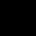

In [126]:
VF.to_pil_image(torch.from_numpy(labels[num_non_zero_per_row < 25][1050].reshape(36, 36)))

In [100]:
hist, bins = np.histogram(num_non_zero_per_row)

In [101]:
hist

array([2541, 2183, 3464,  999,  204,   32,    7,    2,    2,    1])

In [102]:
bins

array([  0. ,  53.7, 107.4, 161.1, 214.8, 268.5, 322.2, 375.9, 429.6,
       483.3, 537. ])

(array([2.541e+03, 2.183e+03, 3.464e+03, 9.990e+02, 2.040e+02, 3.200e+01,
        7.000e+00, 2.000e+00, 2.000e+00, 1.000e+00]),
 array([  0. ,  53.7, 107.4, 161.1, 214.8, 268.5, 322.2, 375.9, 429.6,
        483.3, 537. ]),
 <BarContainer object of 10 artists>)

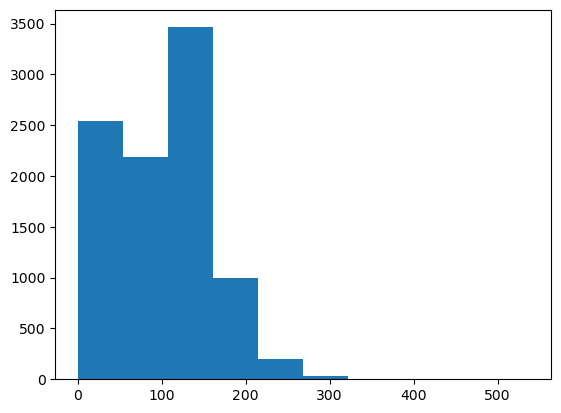

In [120]:
plt.hist(x=num_non_zero_per_row)

In [164]:
data = torch.from_numpy(np.vstack(merged['data'].to_numpy()))
labels = torch.from_numpy(np.vstack(merged['labels'].to_numpy()))

p = np.random.permutation(len(data))
data, labels = data[p], labels[p]

offset = int(len(data) * .8)
X_train, X_valid = data[:offset], data[offset:]
Y_train, Y_valid = labels[:offset].float().reshape(-1, 1, 36, 36), labels[offset:].float().reshape(-1, 1, 36, 36)

scaler = RobustScaler()
scaler.fit(X_train)
X_train = torch.tensor(scaler.transform(X_train)).float().reshape(-1, 1, 36, 36)
X_valid = torch.tensor(scaler.transform(X_valid)).float().reshape(-1, 1, 36, 36)

num_non_zero_y = torch.count_nonzero(labels[:offset], axis=1)
examples_to_augment = X_train[num_non_zero_y > 25]
labels_to_augment = Y_train[num_non_zero_y > 25]

rolled_x, rolled_y = [], []
for i in range(1, 36):
  rolled_x.append(torch.roll(examples_to_augment, i, dims=3))
  rolled_y.append(torch.roll(labels_to_augment, i, dims=3))

X_train, Y_train = torch.vstack((X_train, *rolled_x)), torch.vstack((Y_train, *rolled_y))

flipper = v2.RandomVerticalFlip(1)
X_train, Y_train = torch.vstack((X_train, flipper(examples_to_augment))), torch.vstack((Y_train, flipper(labels_to_augment)))

train_dataset = WellsDataset(X_train, Y_train, None)
valid_dataset = WellsDataset(X_valid, Y_valid, None)

train_dataloader = DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(valid_dataset, batch_size=128)

# Classification Data

In [23]:
def build_test_dataframe():
  data_dir = './test/images/'
  data_dict = []
  pattern = r'well_(\d+)_patch_(\d+)\.npy'
  for i, filename in enumerate(os.listdir(data_dir)):
      example = np.load(data_dir + filename)
      match = re.match(pattern, filename)
      name = filename[:-4]
      if match:
          well_number = int(match.group(1))  # Extract well number
          patch_number = int(match.group(2)) # Extract patch number
      else:
          print("Filename format does not match the expected pattern.")  

      data_dict.append((name, well_number, patch_number, example.flatten()))

  df = pd.DataFrame(data=data_dict, columns=['filename', 'well_number', 'patch_number', 'data'])
  return df.sort_values(by=['well_number','patch_number'])

def build_dataframe():
    data_dir = './train/images/'
    data_dict = []
    pattern = r'well_(\d+)_patch_(\d+)\.npy'
    for i, filename in enumerate(os.listdir(data_dir)):
        example = np.load(data_dir + filename)
        match = re.match(pattern, filename)
        if match:
            well_number = int(match.group(1))  # Extract well number
            patch_number = int(match.group(2)) # Extract patch number
        else:
            print("Filename format does not match the expected pattern.")  

        data_dict.append((filename, well_number, patch_number, example.flatten()))

    df = pd.DataFrame(data=data_dict, columns=['filename', 'well_number', 'patch_number', 'data'])

    df_y = pd.read_csv('train/y_train.csv')
    df_y['Unnamed: 0'] = df_y['Unnamed: 0'] + '.npy'

    # Create single dataframe with data and labels as lists
    merged = pd.merge(df, df_y, how='left', left_on='filename', right_on='Unnamed: 0')
    data_columns = [str(i) for i in range(1296)]
    labeled_data = merged[data_columns].to_numpy()
    # Convert missing labels to all zeros
    labeled_data = np.nan_to_num(labeled_data)
    merged['labels'] = labeled_data.tolist()
    merged = merged.rename(columns={'Unnamed: 0':'label_name'})
    merged = merged.fillna(0.0)

    data = torch.from_numpy(np.vstack(merged['data'].to_numpy(dtype=np.ndarray)))
    # Remove corruputed samples
    outliers = ((data.min(dim=1, keepdim=True).values == -999.2500) == True).flatten()

    merged = merged.drop(merged.loc[outliers.tolist()].index)
    return merged

In [24]:
train_dataframe = build_dataframe()
valid_dataframe = build_test_dataframe()

In [35]:

data = torch.from_numpy(np.vstack(train_dataframe['data'].to_numpy()))
data = torch.nan_to_num(data)
labels = torch.from_numpy(np.vstack(train_dataframe['well_number'].to_numpy())).squeeze() - 1

valid_data = torch.from_numpy(np.vstack(valid_dataframe['data'].to_numpy()))
valid_data = torch.nan_to_num(valid_data)
valid_labels = torch.from_numpy(np.vstack(valid_dataframe['well_number'].to_numpy())).squeeze() - 1

X_train, X_valid = data, valid_data
Y_train, Y_valid = labels, valid_labels

scaler = RobustScaler()
scaler.fit(X_train)
X_train = torch.tensor(scaler.transform(X_train)).float().reshape(-1, 1, 36, 36)
X_valid = torch.tensor(scaler.transform(X_valid)).float().reshape(-1, 1, 36, 36)

examples_to_augment = X_train
labels_to_augment = Y_train

rolled_x, rolled_y = [], []
for i in range(1, 36):
    rolled_x.append(torch.roll(examples_to_augment, i, dims=3))
    rolled_y.append(labels_to_augment)

X_train, Y_train = torch.vstack((X_train, *rolled_x)), torch.hstack((Y_train, *rolled_y))

flipper = v2.RandomVerticalFlip(1)
X_train, Y_train = torch.vstack((X_train, flipper(examples_to_augment))), torch.hstack((Y_train, labels_to_augment))

train_dataset = WellsDataset(X_train, Y_train, None)
valid_dataset = WellsDataset(X_valid, Y_valid, None)

train_dataloader = DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(valid_dataset, batch_size=128)


In [26]:
X_train.shape

torch.Size([349095, 1, 36, 36])

In [27]:
Y_train.shape

torch.Size([349095])

In [36]:
X_valid.shape

torch.Size([2538, 1, 36, 36])

In [37]:
Y_valid.shape

torch.Size([2538])

# Build Individually Normalized Dataset

In [6]:
data_dir = './train/images/'
output_dir = './train/processed_images/'
for i, filename in enumerate(os.listdir(data_dir)):
    example = np.load(data_dir + filename)
    scaled = RobustScaler().fit_transform(example)
    np.save(output_dir + filename, scaled)